# Problem Statement
How can we leverage the available data to predict the likelihood of a hotel being canceled?

Predicting cancellations with high accuracy can significantly reduce the chances and costs associated with overbooking, such as compensating guests when no rooms are available.

In [1]:
import pandas as pd
import numpy as np

In [2]:
hotel_bookings = pd.read_csv('/content/hotel_bookings.csv')

In [3]:
hotel_bookings.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
missing_values= hotel_bookings.isnull().sum()

In [5]:
missing_values=missing_values[missing_values>0]

In [6]:
print(missing_values)

children         4
country        488
agent        16340
company     112593
dtype: int64


In [7]:
hotel_bookings['children'].fillna(0,inplace=True)
hotel_bookings['country'].fillna('Unknown',inplace=True)
hotel_bookings['agent'].fillna(0,inplace=True)
hotel_bookings['company'].fillna(0,inplace=True)

<ipython-input-7-77405e4d4847>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_bookings['children'].fillna(0,inplace=True)
<ipython-input-7-77405e4d4847>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [8]:
missing_after_imputation= hotel_bookings.isnull().sum().sum()
missing_after_imputation

np.int64(0)

In [9]:
data_types=hotel_bookings.dtypes
data_types

,0
hotel,object
is_canceled,int64
lead_time,int64
arrival_date_year,int64
arrival_date_month,object
arrival_date_week_number,int64
arrival_date_day_of_month,int64
stays_in_weekend_nights,int64
stays_in_week_nights,int64
adults,int64


In [10]:
# Convert 'reservation_status_date' to a datetime data type
hotel_bookings['reservation_status_date'] = pd.to_datetime(hotel_bookings['reservation_status_date'])

In [11]:
#Let us check for inconsistencies in the data
no_guests=hotel_bookings[(hotel_bookings['adults']==0) &
                         (hotel_bookings['children']==0) &
                         (hotel_bookings['babies']==0)]
len(no_guests)

180

In [12]:
# Check for bookings with zero total stay but not cancelled
zero_stay= hotel_bookings[(hotel_bookings['stays_in_weekend_nights']==0) &
                          (hotel_bookings['stays_in_week_nights']==0) &
                          (hotel_bookings['is_canceled']==0)]
len(zero_stay)

680

In [13]:
# Removing inconsistent records
hotel_bookings=hotel_bookings[~((hotel_bookings['adults']==0) &
                                (hotel_bookings['children']==0) &
                                (hotel_bookings['babies']==0))]

In [14]:
hotel_bookings=hotel_bookings[~((hotel_bookings['stays_in_weekend_nights']==0) &
                          (hotel_bookings['stays_in_week_nights']==0) &
                          (hotel_bookings['is_canceled']==0))]

In [15]:
#extract all the object type columns in the dataset

cat_columns = ['hotel', 'is_canceled','meal', 'country', 'market_segment',
       'distribution_channel','is_repeated_guest', 'reserved_room_type', 'assigned_room_type',
       'deposit_type', 'customer_type', 'reservation_status']

In [16]:
from enum import unique
# Unique values in each cat columns
print(f"Unique values by categorical columns\n".upper())
for cat_column in cat_columns:
  unique_values=hotel_bookings[cat_column].unique()
  print(f"\n{cat_column}: \n{unique_values}\n")
  print('-'*70)

UNIQUE VALUES BY CATEGORICAL COLUMNS


hotel: 
['Resort Hotel' 'City Hotel']

----------------------------------------------------------------------

is_canceled: 
[0 1]

----------------------------------------------------------------------

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

----------------------------------------------------------------------

country: 
['GBR' 'PRT' 'USA' 'ESP' 'IRL' 'FRA' 'Unknown' 'ROU' 'NOR' 'OMN' 'ARG'
 'POL' 'DEU' 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS'
 'EST' 'CZE' 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX'
 'MAR' 'UKR' 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF'
 'AGO' 'ISR' 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN'
 'JAM' 'HRV' 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL'
 'GGY' 'KWT' 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL'
 'SEN' 'SYC' 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA'
 'CUB' 'CMR' 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CI

In [17]:
# We can replace Undefined meal with Self atering (SC)
hotel_bookings['meal'].replace('Undefined','SC',inplace=True)

<ipython-input-17-a005b0b9118a>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  hotel_bookings['meal'].replace('Undefined','SC',inplace=True)


In [18]:
# Duplicates
duplicate_rows= hotel_bookings[hotel_bookings.duplicated()]
len(duplicate_rows)

31926

In [19]:
#Remove duplicate rows
hotel_bookings.drop_duplicates(inplace=True)

In [20]:
len(hotel_bookings)

86662

## Data Exploration

#### Statistical Summaries

In [21]:
# statistical summaries for numerical column
statistical_summaries= hotel_bookings.describe()
statistical_summaries

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date
count,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,...,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662.000000,86662
mean,0.277042,80.277469,2016.212215,26.819621,15.818006,1.011193,2.641123,1.880409,0.139265,0.010858,...,0.030555,0.184371,0.268180,80.966687,10.932658,0.750052,107.216171,0.084674,0.700122,2016-08-31 14:27:37.141538304
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,2014-10-17 00:00:00
25%,0.000000,12.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,72.860000,0.000000,0.000000,2016-03-18 00:00:00
50%,0.000000,50.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,99.000000,0.000000,0.000000,2016-09-08 00:00:00
75%,1.000000,125.750000,2017.000000,37.000000,23.000000,2.000000,4.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,234.000000,0.000000,0.000000,134.400000,0.000000,1.000000,2017-03-06 00:00:00
max,1.000000,709.000000,2017.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,...,26.000000,72.000000,18.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000,2017-09-14 00:00:00
std,0.447540,86.069128,0.685931,13.653116,8.836041,1.027535,2.035377,0.622267,0.456838,0.113825,...,0.370486,1.736924,0.709906,109.922461,53.872101,10.028099,54.386968,0.282226,0.832610,NaN


### Visualizations

In [22]:
from matplotlib import pyplot as plt
import seaborn as sns

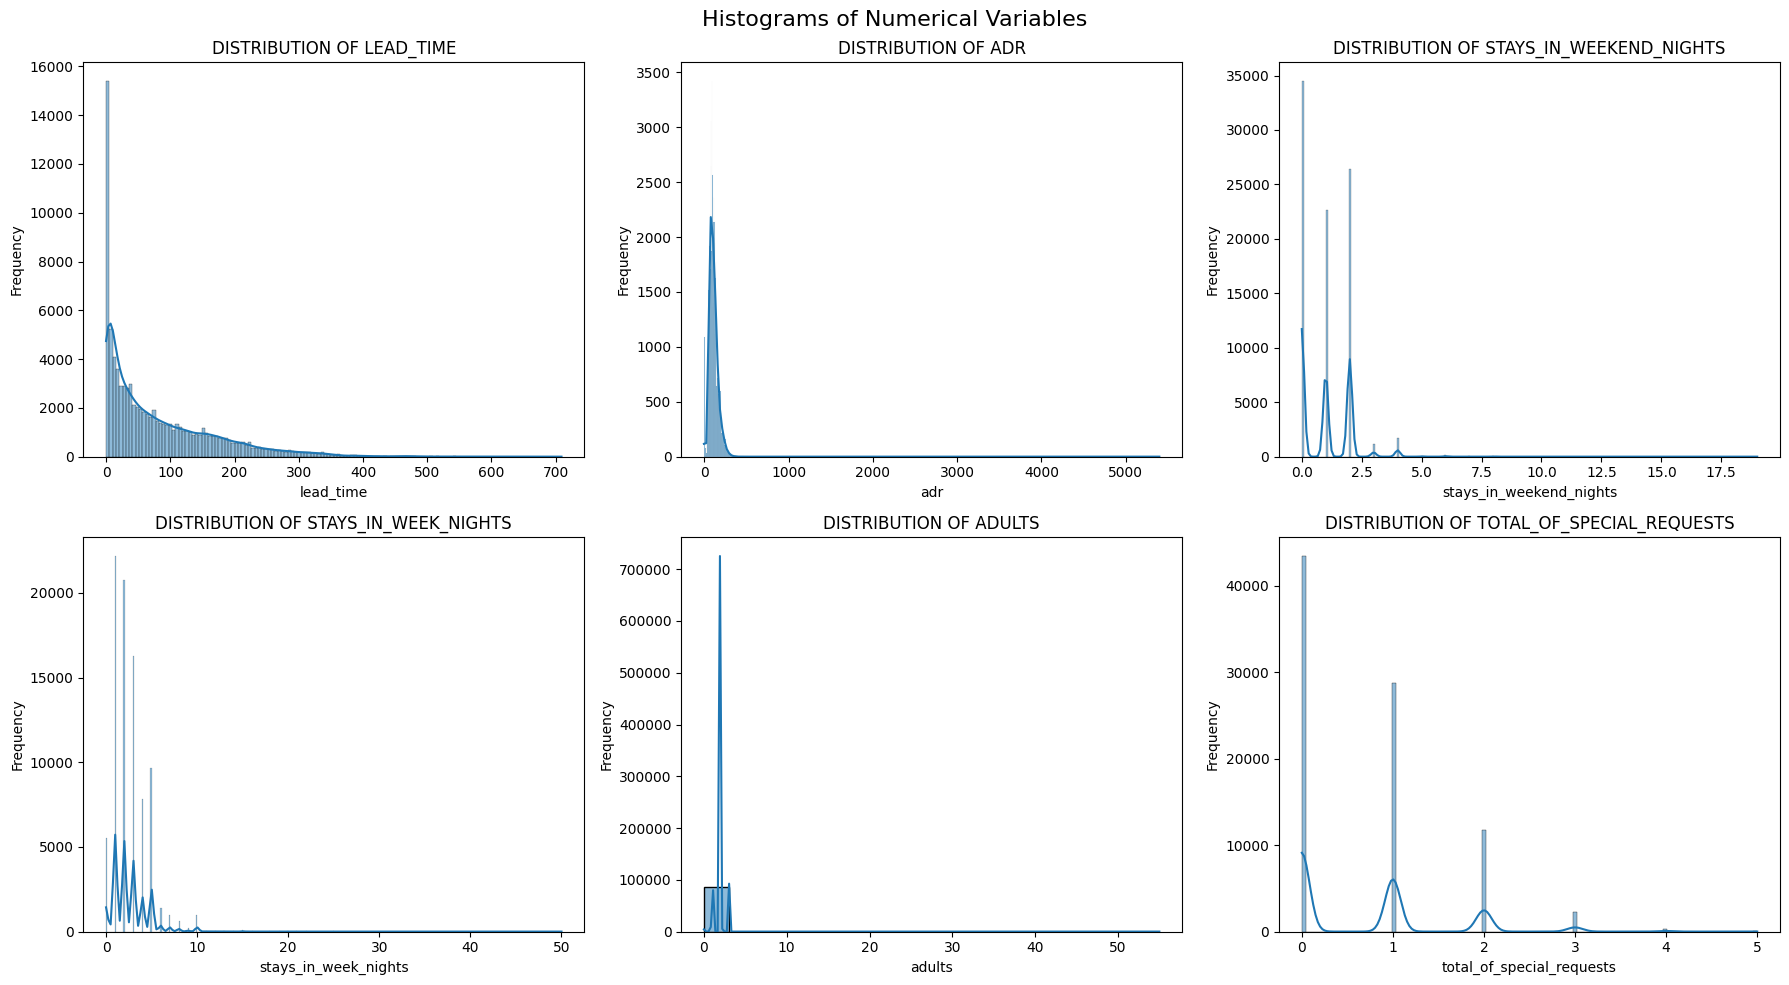

In [23]:
# Histograms of numerical variables to understand the distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Histograms of Numerical Variables',fontsize=16)

variables=['lead_time','adr','stays_in_weekend_nights','stays_in_week_nights','adults','total_of_special_requests']
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    sns.histplot(data=hotel_bookings, x=var, kde=True, ax=ax)
    ax.set_title(f'Distribution of {var}'.upper())
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

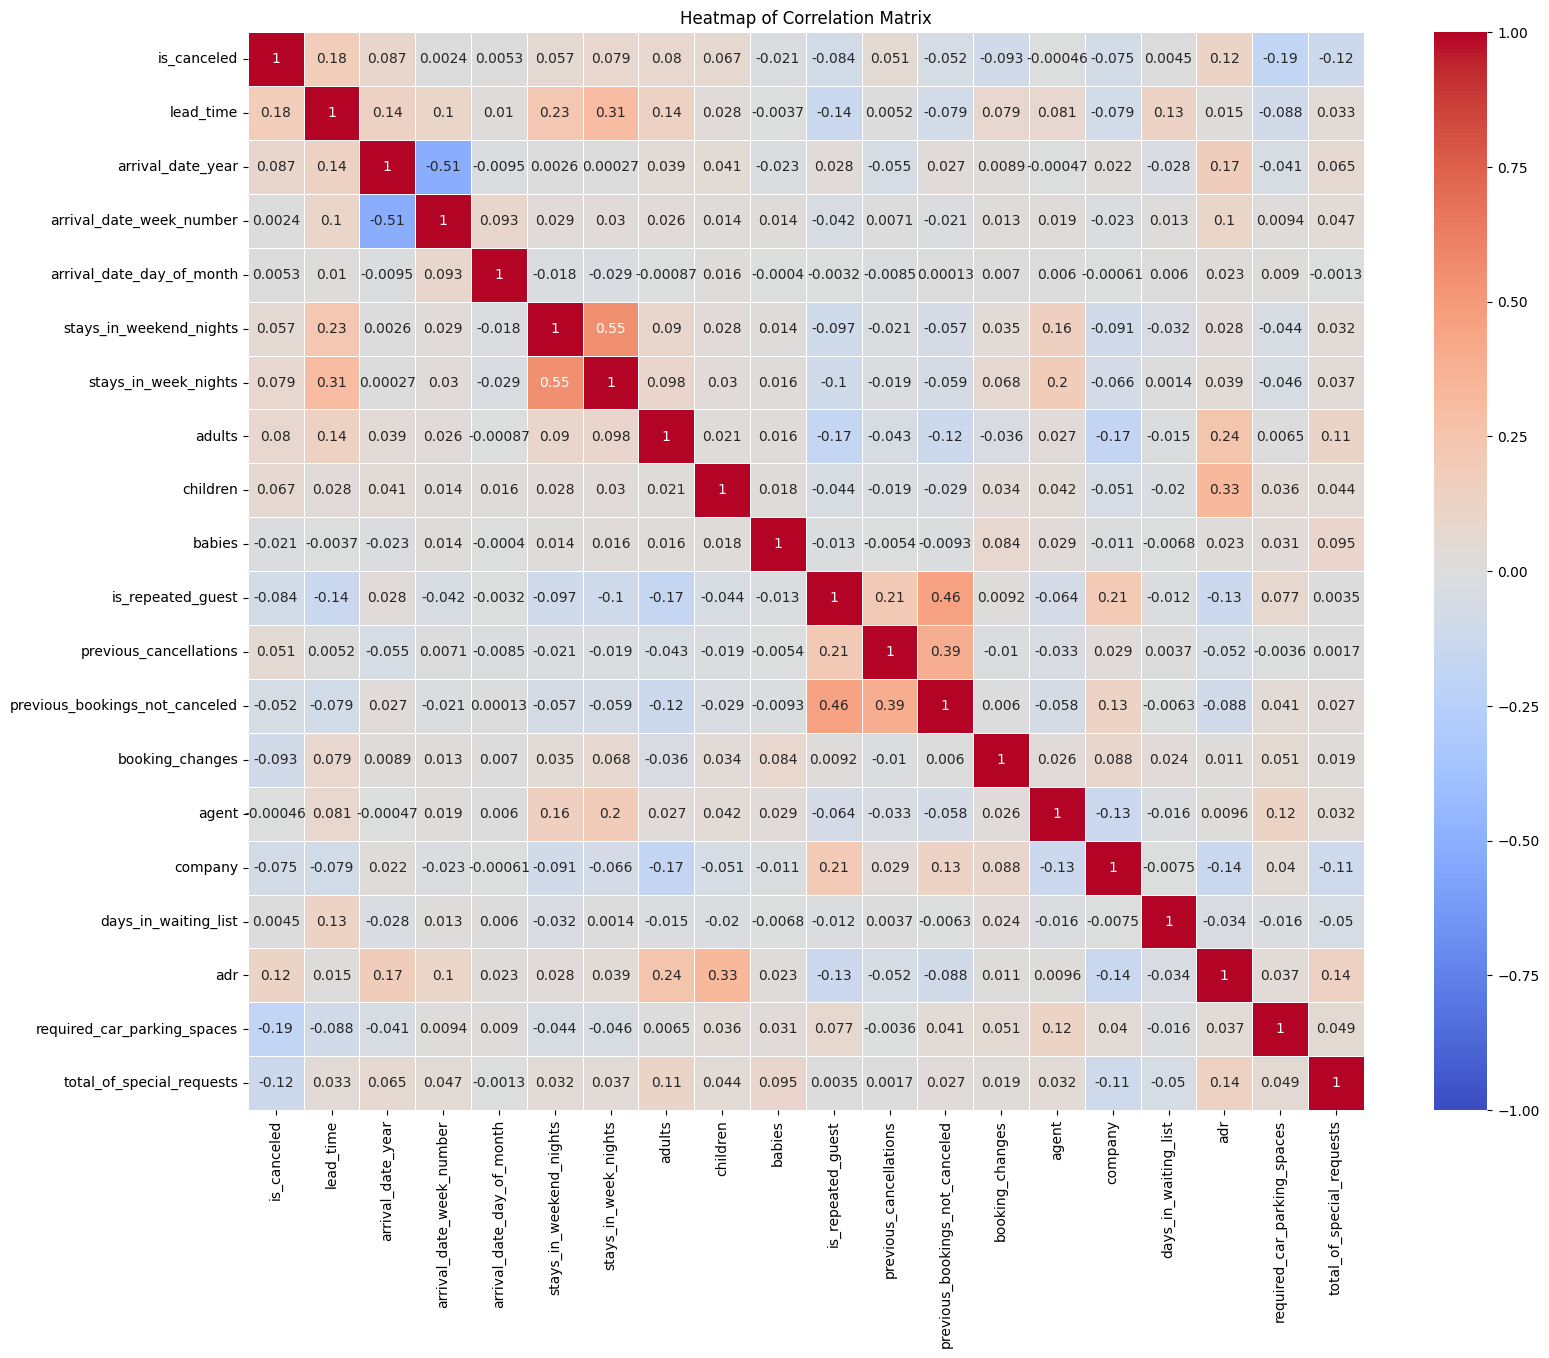

In [24]:
# Correlation Matrix
numeric_columns = hotel_bookings.select_dtypes(include=['float64','int64'])
corr_matrix=numeric_columns.corr()
plt.figure(figsize=(18,14))
sns.heatmap(corr_matrix,annot=True,cmap='coolwarm',linewidths=0.5, vmax=1.0, vmin=-1.0)
plt.title('Heatmap of Correlation Matrix')
plt.show()


stays_in_weekend_nights and stays_in_week_nights have a positive correlation (0.55) indicating that longer stays often span both weekends and weekdays

### Feature Engineering

##### Creating New Features

In [25]:
hotel_bookings['total_guests'] = hotel_bookings['adults'] + hotel_bookings['children'] + hotel_bookings['babies']
hotel_bookings['booking_duration'] = hotel_bookings['stays_in_weekend_nights'] + hotel_bookings['stays_in_week_nights']
hotel_bookings['booking_change_rate']= hotel_bookings['booking_changes']/hotel_bookings['total_guests']

##### Encoding categorical columns

In [26]:
hotel_bookings['hotel_encoded']=hotel_bookings['hotel'].map({'City Hotel':0,'Resort Hotel':1})

In [27]:
# One Hot Encoding for nominal features
nominal_columns=['hotel','meal','market_segment','distribution_channel','reserved_room_type',
                 'assigned_room_type','customer_type','reservation_status']

hotel_bookings= pd.get_dummies(data=hotel_bookings, columns=nominal_columns, drop_first=True, dtype=int)


In [28]:
# Label Encoding for arrival date month
month_ordering=['January','February','March','April','May','June','July','August','September','October','November','December']
hotel_bookings['arrival_date_month_encoded']=hotel_bookings['arrival_date_month'].apply(lambda x: month_ordering.index(x)+1 if x in month_ordering else 0)

In [29]:
hotel_bookings['arrival_date_month_encoded'].value_counts()

,count
arrival_date_month_encoded,
8,11194
7,9989
5,8298
4,7873
6,7723
3,7442
10,6843
9,6660
2,6037


In [30]:
#Label Encoding for deposit_type
deposit_mapping={'No Deposit':0,'Non Refund':1,'Refundable':2}
hotel_bookings['deposit_type_encoded']=hotel_bookings['deposit_type'].map(deposit_mapping)

In [31]:
# Splitting reservation_status_date into year, month, and day columns

hotel_bookings['reservation_status_year'] = hotel_bookings['reservation_status_date'].dt.year
hotel_bookings['reservation_status_month'] = hotel_bookings['reservation_status_date'].dt.month
hotel_bookings['reservation_status_day'] = hotel_bookings['reservation_status_date'].dt.day

In [32]:
# Frequency Distribution of country to get top 10 countries
country_counts=hotel_bookings['country'].value_counts().head(10)
country_counts

,count
country,
PRT,26876
GBR,10402
FRA,8814
ESP,7229
DEU,5385
ITA,3057
IRL,3014
BEL,2079
BRA,1989


In [33]:
top_10_countries = country_counts.index.tolist()

In [34]:
hotel_bookings['country_grouped']=hotel_bookings['country'].apply(lambda x: x if x in top_10_countries else 'Other')

In [35]:
hotel_bookings=pd.get_dummies(data=hotel_bookings,columns=['country_grouped'],dtype=int)

In [36]:
hotel_bookings.drop(columns=['country','arrival_date_month','reservation_status_date','deposit_type'],inplace=True)

In [37]:
hotel_bookings.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,country_grouped_BRA,country_grouped_DEU,country_grouped_ESP,country_grouped_FRA,country_grouped_GBR,country_grouped_IRL,country_grouped_ITA,country_grouped_NLD,country_grouped_Other,country_grouped_PRT
2,0,7,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,13,2015,27,1,0,1,1,0.0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,14,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,9,2015,27,1,0,2,2,0.0,0,...,0,0,0,0,0,0,0,0,0,1


### Model Building

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X=hotel_bookings.drop('is_canceled',axis=1)
y=hotel_bookings['is_canceled']

In [40]:
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [41]:
#Splitting the temporary set into validation and test sets
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score

#### Logistic regression

In [43]:
log_reg= LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [44]:
# Accuracy on the validation data
log_reg_val_acc=accuracy_score(y_val,log_reg.predict(X_val))
print("Logistic Regression Accuracy on Validation Data - ",log_reg_val_acc)

Logistic Regression Accuracy on Validation Data -  0.8806062004769598


In [45]:
#Confusion Matrix on validation data
cm_log_reg= confusion_matrix(y_val,log_reg.predict(X_val))
print("Confusion Matrix for Logistic Regression - \n",cm_log_reg)

Confusion Matrix for Logistic Regression - 
 [[9204  194]
 [1358 2243]]


In [46]:
#F1 Score
f1_log_reg=f1_score(y_val,log_reg.predict(X_val))
print("F1 Score for Logistic Regression - \n",f1_log_reg)

F1 Score for Logistic Regression - 
 0.7429612454455118


In [47]:
#ROC-AUC Score
roc_auc_log_reg=roc_auc_score(y_val,log_reg.predict(X_val))
print("ROC-AUC Score for Logistic Regression - ",roc_auc_log_reg)

ROC-AUC Score for Logistic Regression -  0.8011199213478982


#### Decision Tree

In [48]:
decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
# Accuracy on validation set
dt_val_acc=accuracy_score(y_val,decision_tree.predict(X_val))
print("Decision Tree Accuracy on Validation Data - ",dt_val_acc)

Decision Tree Accuracy on Validation Data -  1.0


In [50]:
# Confusion Matrix
cm_dt=confusion_matrix(y_val,decision_tree.predict(X_val))
print("Confusion Matrix for Decision Tree - \n",cm_dt)

Confusion Matrix for Decision Tree - 
 [[9398    0]
 [   0 3601]]


In [51]:
# F1 Score
f1_dt=f1_score(y_val,decision_tree.predict(X_val))
print("F1 Score for Decision Tree - \n",f1_dt)

F1 Score for Decision Tree - 
 1.0


In [52]:
# ROC-AUC Curve
roc_auc_dt=roc_auc_score(y_val,decision_tree.predict(X_val))
print("ROC-AUC Score for Decision Tree - ",roc_auc_dt)

ROC-AUC Score for Decision Tree -  1.0


The result is surprising as the model is giving perfect predictions. Let us explore further

<Axes: >

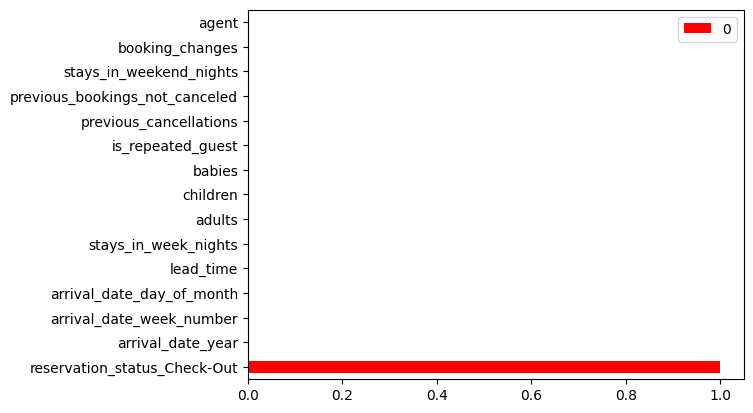

In [53]:
# Feature Importance
pd.DataFrame(data=decision_tree.feature_importances_,index=X_train.columns).sort_values(by=0,ascending=False)[:15].plot(kind='barh',color='r')

The entire predictive power comes from one particular feature **reservation _status_Check-Out**.

In [54]:
pd.DataFrame(hotel_bookings[['is_canceled','reservation_status_Check-Out']]).describe()

,is_canceled,reservation_status_Check-Out
count,86662.000000,86662.000000
mean,0.277042,0.722958
std,0.447540,0.447540
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


We can see that it mimics the is_canceled feature and hence, able to predict everything perfectly.

In [55]:
# Dropping the feature reservation_status_Check-Out
X = hotel_bookings.drop(columns=['is_canceled','reservation_status_Check-Out'])
y = hotel_bookings['is_canceled']

In [56]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [57]:
log_reg= LogisticRegression(random_state=42)
log_reg.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [58]:
#Accuracy on validation set
log_reg_val_acc=accuracy_score(y_val,log_reg.predict(X_val))
print("Logistic Regression Accuracy on Validation Data - ",log_reg_val_acc)

Logistic Regression Accuracy on Validation Data -  0.7504423417185937


In [59]:
#Confusion Matrix
cm_log_reg= confusion_matrix(y_val,log_reg.predict(X_val))
print("Confusion Matrix for Logistic Regression - \n",cm_log_reg)

Confusion Matrix for Logistic Regression - 
 [[9259  139]
 [3105  496]]


In [60]:
#F1 Score
f1_log_reg=f1_score(y_val,log_reg.predict(X_val))
print("F1 Score for Logistic Regression - \n",f1_log_reg)

F1 Score for Logistic Regression - 
 0.23418319169027385


In [61]:
#ROC-AUC Curve
roc_auc_log_reg=roc_auc_score(y_val,log_reg.predict(X_val))
print("ROC-AUC Score for Logistic Regression - ",roc_auc_log_reg)

ROC-AUC Score for Logistic Regression -  0.5614745679343877


In [62]:
#Decision Tree
decision_tree=DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(random_state=42)

In [63]:
#Accuracy
dt_val_acc=accuracy_score(y_val,decision_tree.predict(X_val))
print("Decision Tree Accuracy on Validation Data - ",dt_val_acc)

Decision Tree Accuracy on Validation Data -  0.9316870528502192


In [64]:
#Confusion matrix
cm_dt=confusion_matrix(y_val,decision_tree.predict(X_val))
print("Confusion Matrix for Decision Tree - \n",cm_dt)

Confusion Matrix for Decision Tree - 
 [[8961  437]
 [ 451 3150]]


In [65]:
# F1 Score
f1_dt=f1_score(y_val,decision_tree.predict(X_val))
print("F1 Score for Decision Tree - \n",f1_dt)

F1 Score for Decision Tree - 
 0.8764607679465777


In [66]:
# ROC-AUC Curve
roc_auc_dt=roc_auc_score(y_val,decision_tree.predict(X_val))
print("ROC-AUC Score for Decision Tree - ",roc_auc_dt)


ROC-AUC Score for Decision Tree -  0.9141288783902275


#### Random Forest

In [67]:
random_forest=RandomForestClassifier(random_state=42)
random_forest.fit(X_train,y_train)

RandomForestClassifier(random_state=42)

In [68]:
#Accuracy
rf_val_acc=accuracy_score(y_val,random_forest.predict(X_val))
print("Random Forest Accuracy on Validation Data - ",rf_val_acc)

Random Forest Accuracy on Validation Data -  0.9351488576044311


In [69]:
#Confusion Matrix
cm_rf=confusion_matrix(y_val,random_forest.predict(X_val))
print("Confusion Matrix for Random Forest - \n",cm_rf)

Confusion Matrix for Random Forest - 
 [[9250  148]
 [ 695 2906]]


In [70]:
#F1 Score
f1_rf=f1_score(y_val,random_forest.predict(X_val))
print("F1 Score for Random Forest - \n",f1_rf)

F1 Score for Random Forest - 
 0.873328324567994


In [71]:
#ROC-AUC Curve
roc_auc_rf=roc_auc_score(y_val,random_forest.predict(X_val))
print("ROC-AUC Score for Random Forest - ",roc_auc_rf)

ROC-AUC Score for Random Forest -  0.895625012299733


#### Support Vector Machine

In [72]:
svm=SVC(random_state=42)
svm.fit(X_train,y_train)

SVC(random_state=42)

In [73]:
#Accuracy
svm_val_acc=accuracy_score(y_val,svm.predict(X_val))
print("SVM Accuracy on Validation Data - ",svm_val_acc)

SVM Accuracy on Validation Data -  0.722978690668513


In [74]:
#Confusion Matrix
cm_svm=confusion_matrix(y_val,svm.predict(X_val))
print("Confusion Matrix for SVM - \n",cm_svm)

Confusion Matrix for SVM - 
 [[9398    0]
 [3601    0]]


In [75]:
#F1 Score
f1_svm=f1_score(y_val,svm.predict(X_val))
print("F1 Score for SVM - \n",f1_svm)

F1 Score for SVM - 
 0.0


In [76]:
#ROC-AUC Curve
roc_auc_svm=roc_auc_score(y_val,svm.predict(X_val))
print("ROC-AUC Score for SVM - ",roc_auc_svm)

ROC-AUC Score for SVM -  0.5


SVC is the worst of them all. We can choose the Random Forest Classifier as it was showing good results and finw tune the model for better results.

In [77]:
# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV
param_grid={
    'n_estimators':[150,250, 500],
    'max_features':['sqrt','log2', None],
    'max_depth':[3,6,9,12,15]}

In [78]:
grid_search=GridSearchCV(estimator=random_forest,param_grid=param_grid,cv=5,n_jobs=-1,verbose=2)

In [79]:
grid_search.fit(X_train,y_train)
print(grid_search.best_estimator_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
RandomForestClassifier(max_depth=15, max_features=None, n_estimators=150,
                       random_state=42)


In [81]:
#Accuracy
rf_val_acc=accuracy_score(y_val,grid_search.predict(X_val))
print("Random Forest Accuracy on Validation Data - ",rf_val_acc)

Random Forest Accuracy on Validation Data -  0.947995999692284


In [82]:
#Confusion Matrix
cm_rf=confusion_matrix(y_val,grid_search.predict(X_val))
print("Confusion Matrix for Random Forest - \n",cm_rf)

Confusion Matrix for Random Forest - 
 [[9316   82]
 [ 594 3007]]


In [83]:
#F1 Score
f1_rf=f1_score(y_val,grid_search.predict(X_val))
print("F1 Score for Random Forest - \n",f1_rf)

F1 Score for Random Forest - 
 0.8989536621823617


In [84]:
# ROC-AUC Curve
roc_auc_rf=roc_auc_score(y_val,grid_search.predict(X_val))
print("ROC-AUC Score for Random Forest - ",roc_auc_rf)

ROC-AUC Score for Random Forest -  0.9131602799558113


#### Model Validation

In [85]:
# Accuracy
rf_gs_acc= accuracy_score(y_test,grid_search.predict(X_test))
print("Random Forest Accuracy on Test Data - ",rf_gs_acc)

Random Forest Accuracy on Test Data -  0.946


In [86]:
# Confusion Matrix
cm_gs_rf=confusion_matrix(y_test,grid_search.predict(X_test))
print("Confusion Matrix for Random Forest - \n",cm_rf)

Confusion Matrix for Random Forest - 
 [[9316   82]
 [ 594 3007]]


In [87]:
# F1 Score
f1_gs_rf=f1_score(y_test,grid_search.predict(X_test))
print("F1 Score for Random Forest - \n",f1_rf)

F1 Score for Random Forest - 
 0.8989536621823617


In [88]:
# ROC-AUC Curve
roc_auc_gs_rf=roc_auc_score(y_test,grid_search.predict(X_test))
print("ROC-AUC Score for Random Forest - ",roc_auc_rf)

ROC-AUC Score for Random Forest -  0.9131602799558113


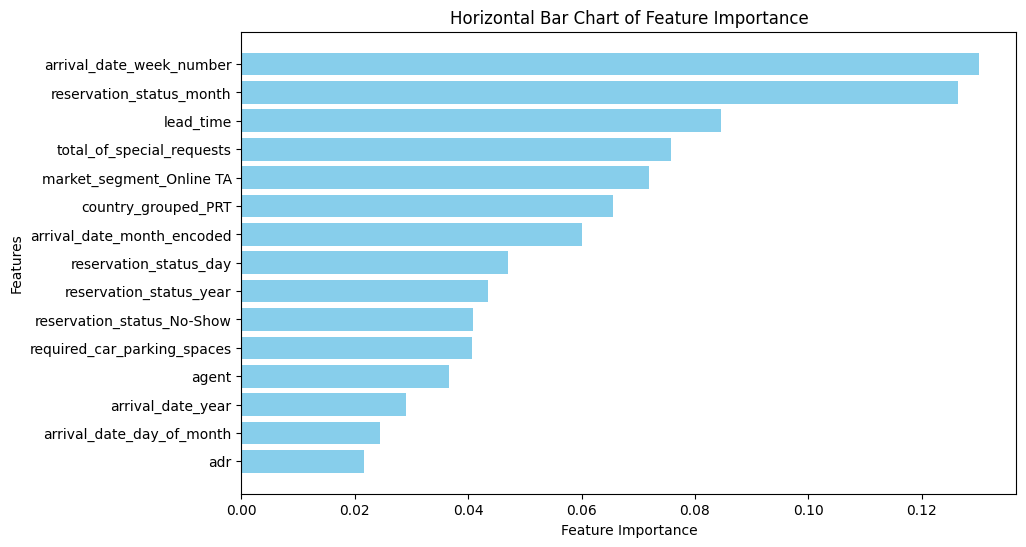

In [89]:
feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances.index[:15], feature_importances['importance'][:15], color='skyblue')  # Top 15 features
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Horizontal Bar Chart of Feature Importance")
plt.gca().invert_yaxis() # Invert y-axis to show highest importance at top
plt.show()


### Insights


*   **arrival_date_week_number** has highest feature importance. Certain weeks, possibly during peak hoilday seasons or major events, might see a surge in cancellations.
*   We can say the same for **reservation status_month** as certain months may follow seasonal trends, holidays, or events. We should consider targeted promotional campaigns in such minths and weeks.
*   **lead_time**  is also a strong indicator . This could be guests who book well in advance are more uncertain about their plans.




